In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
from sklearn.metrics import mean_squared_error, r2_score
import os

In [3]:
DATASETS = {
    "AAPL": "data/AAPL/AAPL_data.csv",
    "BTC": "data/BTC/BTC_data.csv",
    "ETH": "data/ETH/ETH_data.csv",
    "SPY": "data/SPY/SPY_data.csv"
}

In [4]:
FORECAST_INTERVALS = {
    "1_tydzień": {"AAPL": 16 * 7, "BTC": 24 * 7, "ETH": 24 * 7, "SPY": 17 * 7}, # 112 168 168 119
    "2_tygodnie": {"AAPL": 16 * 14, "BTC": 24 * 14, "ETH": 24 * 14, "SPY": 17 * 14}, # 224 336 336 238
    "3_tygodnie": {"AAPL": 16 * 21, "BTC": 24 * 21, "ETH": 24 * 21, "SPY": 17 * 21},
    "1_miesiąc": {"AAPL": 320, "BTC": 744, "ETH": 744, "SPY": 340},
    "2_miesiące": {"AAPL": 320*2, "BTC": 744*2, "ETH": 744*2, "SPY": 340*2},
    "3_miesiące": {"AAPL": "test_len", "BTC": "test_len", "ETH": "test_len", "SPY": "test_len"} # 960 2160 2160 1020
}

In [5]:
def get_data(file, tail=None, custom_test_length=None):
    data = pd.read_csv(file, parse_dates=['timestamp'])
    if tail is not None:
        data = data.tail(tail)
    if custom_test_length is not None:
        test_length = custom_test_length
    else:
        test_length = (data['timestamp'].dt.year == 2025).sum()
    msk = (data.index < len(data) - test_length)
    df_train = data[msk].copy()
    df_test = data[~msk].copy()
    return data, df_train, df_test

def train_model(data):       
    model=auto_arima(data,stepwise=False,seasonal=False)    
    return model

def plot_prediction(real, pred, history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(history)), history, label='Historia', linestyle='--')
    plt.plot(range(len(history), len(history) + len(real)), real, label='Rzeczywiste', marker='o')
    plt.plot(range(len(history), len(history) + len(pred)), pred, label='Predykcja', marker='x')
    plt.title(title)
    plt.xlabel('Notowanie')
    plt.ylabel('Cena "open"')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def train_model(data):       
    model = auto_arima(data, stepwise=False, seasonal=False)    
    return model

In [ ]:
all_results = []

for name, path in DATASETS.items():
    print(f"\n================= {name} =================\n")
    data, df_train, df_test = get_data(path)
    test_len = len(df_test)
    test_values = df_test[['close']].values
    train_values = df_train['close'].values
    forecast_ranges = {}
    for label, source in FORECAST_INTERVALS.items():
        val = source[name]
        forecast_ranges[label] = test_len if val == "test_len" else val

    results_table = []
    best_results = {}
    
    print("Trenowanie modelu ARIMA...")
    model = train_model(train_values)
    print(model.order)

    print("Predykcja...")
    pred_all = model.predict(n_periods=test_len)
    
    for range_name, range_len in forecast_ranges.items():
        if range_len > len(pred_all):
            continue
        pred_slice = pred_all[:range_len].flatten()
        real_slice = test_values[:range_len].flatten()
        mape = np.mean(np.abs((real_slice - pred_slice) / real_slice)) * 100
        r2 = r2_score(real_slice, pred_slice)
        
        results_table.append({
            "Instrument": name,
            "Zakres": range_name,
            "MAPE": mape,
            "R2": r2
        })

        if (range_name not in best_results) or (mape < best_results[range_name]['mape']):
            best_results[range_name] = {
                'mape': mape,
                'r2': r2,
                'pred': pred_slice
            }
            
    df_results = pd.DataFrame(results_table)
    print(f"\nTabela wyników dla {name} (ARIMA - MAPE %):\n")
    print(df_results.pivot_table(index='Instrument', columns='Zakres', values='MAPE').round(2))

    # ZAPIS PLIKÓW Z PREDYKCJAMI I METRYKAMI
    range_name_map = {
        "1_tydzień": "tyg",
        "2_tygodnie": "2tyg",
        "3_tygodnie": "3tyg",
        "1_miesiąc": "msc",
        "2_miesiące": "2msc",
        "3_miesiące": "3msc"
    }

    output_folder = f"wyniki_predykcji/{name.lower()}"
    os.makedirs(output_folder, exist_ok=True)

    for range_name, res in best_results.items():
        okres = range_name_map.get(range_name, range_name)
        podmiot = name.lower()

        preds_filename = f"{podmiot}_{okres}_ARIMA.txt"
        preds_filepath = os.path.join(output_folder, preds_filename)
        np.savetxt(preds_filepath, res["pred"], fmt="%.6f")

        metrics_filename = f"{podmiot}_{okres}_ARIMA_metrics.txt"
        metrics_filepath = os.path.join(output_folder, metrics_filename)
        with open(metrics_filepath, "w") as f:
            f.write(f"{res['mape']:.4f}\n")
            f.write(f"{res['r2']:.4f}\n")

    all_results.append(df_results)


================= AAPL =================

Trenowanie modelu ARIMA...
Predykcja...

Tabela wyników dla AAPL (ARIMA - MAPE %):

Zakres      1_miesiąc  1_tydzień  2_miesiące  2_tygodnie  3_miesiące  \
Instrument                                                             
AAPL             7.27       3.87        6.97        6.93        9.89   

Zakres      3_tygodnie  
Instrument              
AAPL              7.42  

================= BTC =================

Trenowanie modelu ARIMA...
Predykcja...

Tabela wyników dla BTC (ARIMA - MAPE %):

Zakres      1_miesiąc  1_tydzień  2_miesiące  2_tygodnie  3_miesiące  \
Instrument                                                             
BTC              5.83       4.13        4.91        2.64        7.85   

Zakres      3_tygodnie  
Instrument              
BTC               4.43  

================= ETH =================

Trenowanie modelu ARIMA...
Predykcja...

Tabela wyników dla ETH (ARIMA - MAPE %):

Zakres      1_miesiąc  1_tydzień  2_mie

In [6]:
AAPL="data/AAPL/AAPL_data.csv"
BTC="data/BTC/BTC_data.csv"
ETH="data/ETH/ETH_data.csv"
SPY="data/SPY/SPY_data.csv"

In [7]:
def plot_stock_data(csv_file, comapny, column, color):
    df = pd.read_csv(csv_file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, year in enumerate([2021, 2022, 2023, 2024]):
        df_roku = df[df["year"] == year]
        axes[i].plot(df_roku["timestamp"], df_roku["open"], label=f"{year}", color=color)
        axes[i].set_title(f"{comapny} - Przebieg wartości {column} dla roku {year}")
        axes[i].set_xlabel("Data")
        axes[i].set_ylabel("Open")
        axes[i].legend()
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def adf_test(data):
    adf_test=adfuller(data)
    print(f'p-value: {adf_test[1]}')

def stationary_transform(data):
    stationary_data=data.diff().dropna()
    return stationary_data

def train_model(data):       
    model=auto_arima(data,stepwise=False,seasonal=False)    
    return model

def get_data(file, tail=None, custom_test_length=None):
    data = pd.read_csv(file, parse_dates=['timestamp'])
    if tail is not None:
        data=data.tail(tail)
        
    if custom_test_length is not None:
        test_length=custom_test_length
    else:
        test_length = (data['timestamp'].dt.year == 2025).sum()
    
    msk=(data.index<len(data)-test_length)
    df_train=data[msk].copy()
    df_test=data[~msk].copy()  
    
    return data, df_train, df_test 

def get_model_and_plot_forecast(df_train, df_test, column, title):
    model = train_model(df_train[column])
    forecast=model.predict(n_periods=len(df_test))

    df_full = pd.concat([df_train, df_test], ignore_index=True)
    
    if len(df_full) > 8 * len(df_test):
        df_full = df_full.tail(8 * len(df_test)).reset_index(drop=True)

        # Oblicz ile danych treningowych pozostało po przycięciu
        visible_train_len = len(df_full) - len(df_test)

        df_full[f'forecast_{column}'] = [None] * visible_train_len + list(forecast)
        split_idx = visible_train_len
    else:
        df_full[f'forecast_{column}'] = [None] * len(df_train) + list(forecast)
        split_idx = len(df_train)

    # Formatowanie osi czasu
    df_full['timestamp'] = df_full['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

    # Rysowanie wykresu
    ax = df_full.plot(x='timestamp', y=[column, f'forecast_{column}'], title=title)
    ax.set_xticks(range(0, len(df_full), max(1, len(df_full) // 8)))
    ax.axvline(x=split_idx - 0.5, color='gray', linestyle='dashed')
    ax.set_xticklabels(df_full['timestamp'].iloc[::max(1, len(df_full) // 8)], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Obliczanie metryk

    y_true = df_test[column].values
    y_pred = forecast
    nrmse = np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    mape = 100 * np.mean(np.abs((y_true - y_pred) / (y_true)))
    r2 = r2_score(y_true, y_pred)
    
    return model, nrmse, mape, r2

def extract_period(data_train, data_test, period_type='month'):
    data_train['timestamp'] = pd.to_datetime(data_train['timestamp'])
    data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])

    if period_type == 'day':
        last_day = data_train['timestamp'].dt.date.max()
        first_day = data_test['timestamp'].dt.date.min()
        train_filtered = data_train[data_train['timestamp'].dt.date == last_day]
        test_filtered = data_test[data_test['timestamp'].dt.date == first_day]

    elif period_type == 'week':
        train_days = data_train['timestamp'].dt.date.unique()
        last_7_days = sorted(train_days)[-7:]
        train_filtered = data_train[data_train['timestamp'].dt.date.isin(last_7_days)]

        test_days = data_test['timestamp'].dt.date.unique()
        first_7_days = sorted(test_days)[:7]
        test_filtered = data_test[data_test['timestamp'].dt.date.isin(first_7_days)]

    elif period_type == 'month':
        data_train['year_month'] = data_train['timestamp'].dt.to_period('M')
        data_test['year_month'] = data_test['timestamp'].dt.to_period('M')

        last_month = data_train['year_month'].max()
        first_month = data_test['year_month'].min()

        train_filtered = data_train[data_train['year_month'] == last_month]
        test_filtered = data_test[data_test['year_month'] == first_month]

    elif period_type == 'quarter':
        data_train['year_quarter'] = data_train['timestamp'].dt.to_period('Q')
        data_test['year_quarter'] = data_test['timestamp'].dt.to_period('Q')

        last_quarter = data_train['year_quarter'].max()
        first_quarter = data_test['year_quarter'].min()

        train_filtered = data_train[data_train['year_quarter'] == last_quarter]
        test_filtered = data_test[data_test['year_quarter'] == first_quarter]

    else:
        raise ValueError("Nieznany typ okresu. Użyj: 'day', 'week', 'month' lub 'quarter'.")

    return train_filtered.reset_index(drop=True), test_filtered.reset_index(drop=True)
        
def filter_by_hour(data_train, data_test, hour):
    data_train['timestamp'] = pd.to_datetime(data_train['timestamp'])
    data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])

    train_filtered = data_train[data_train['timestamp'].dt.hour == hour]
    test_filtered = data_test[data_test['timestamp'].dt.hour == hour]

    return train_filtered.reset_index(drop=True), test_filtered.reset_index(drop=True)



# Apple

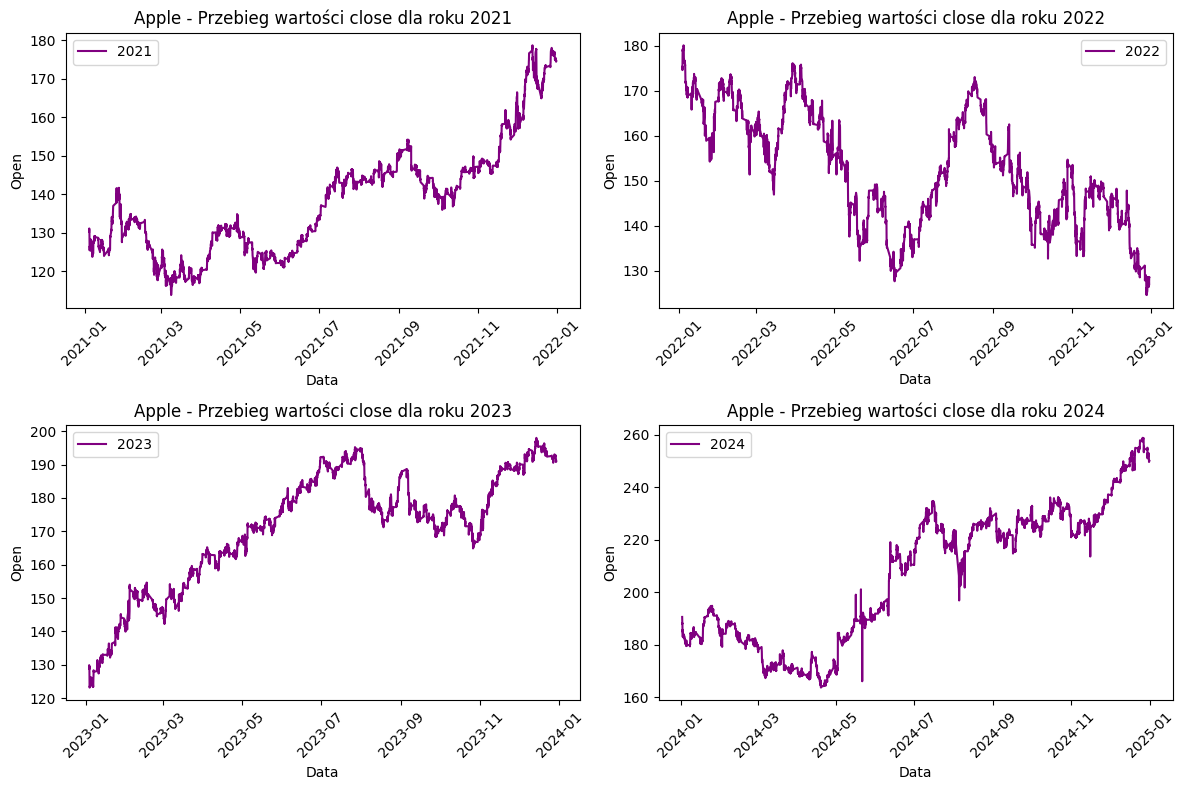

In [8]:
plot_stock_data(AAPL, 'Apple', 'close', 'purple')

In [9]:
aapl_data, aapl_train, aapl_test = get_data(AAPL)
aapl_train_day, aapl_test_day = extract_period(aapl_train, aapl_test, 'day')
aapl_train_week, aapl_test_week = extract_period(aapl_train, aapl_test, 'week')
aapl_train_month, aapl_test_month = extract_period(aapl_train, aapl_test, 'month')
aapl_train_quarter, aapl_test_quarter = extract_period(aapl_train, aapl_test, 'quarter')

aapl_train_h, aapl_test_h = filter_by_hour(aapl_train, aapl_test, 14)
aapl_train_day_h, aapl_test_day_h = filter_by_hour(aapl_train_day, aapl_test_day, 14)
aapl_train_week_h, aapl_test_week_h = filter_by_hour(aapl_train_week, aapl_test_week, 14)
aapl_train_month_h, aapl_test_month_h = filter_by_hour(aapl_train_month, aapl_test_month, 14)
aapl_train_quarter_h, aapl_test_quarter_h = filter_by_hour(aapl_train_quarter, aapl_test_quarter, 14)

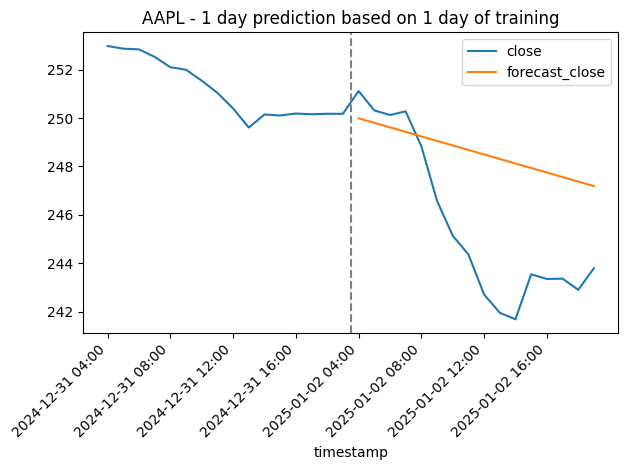

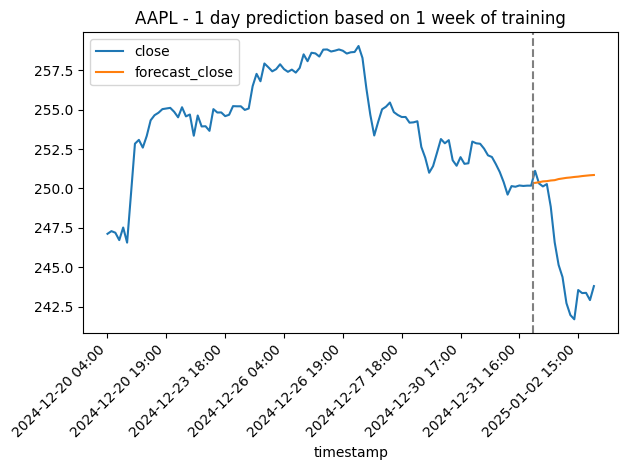

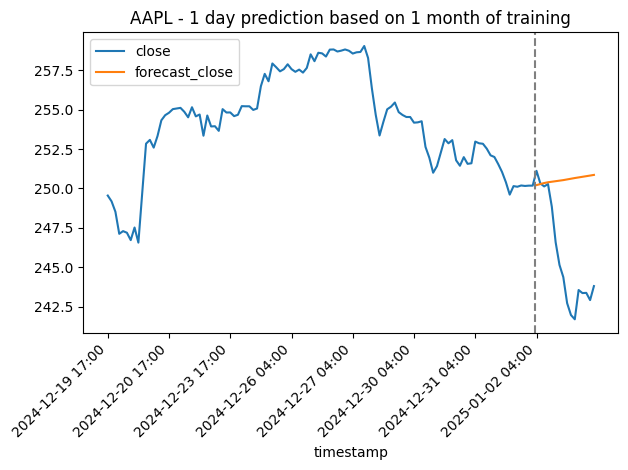

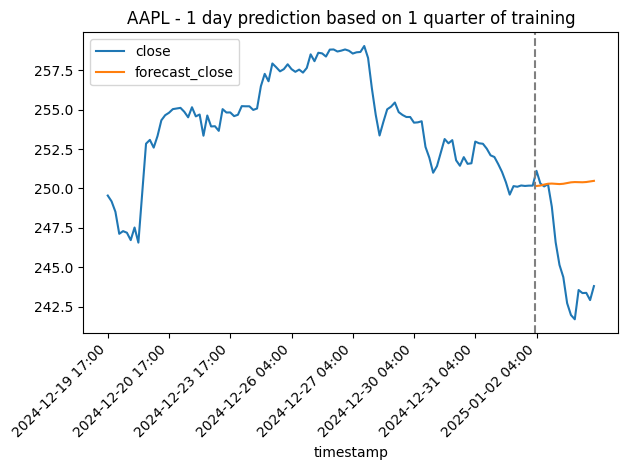

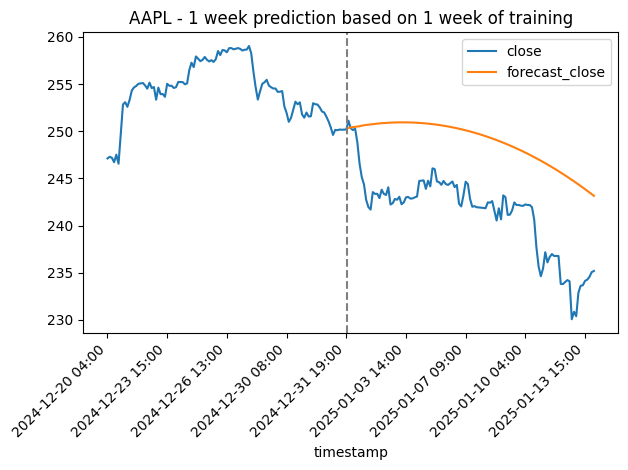

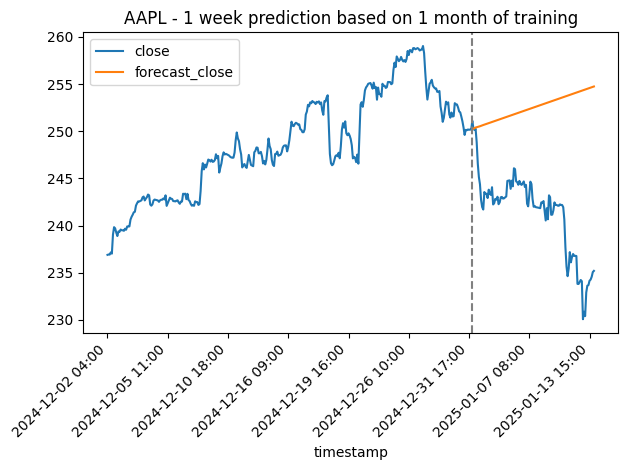

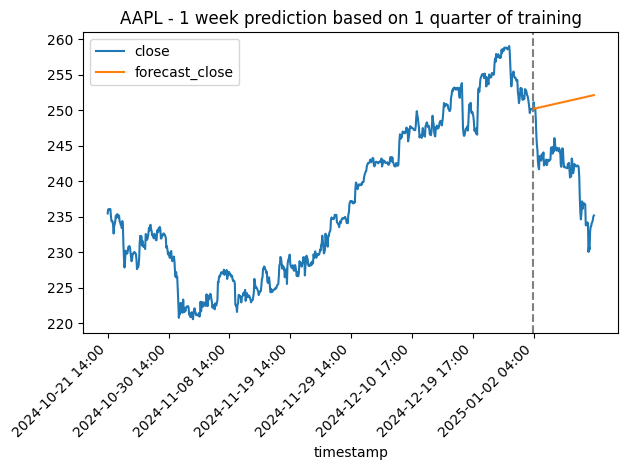

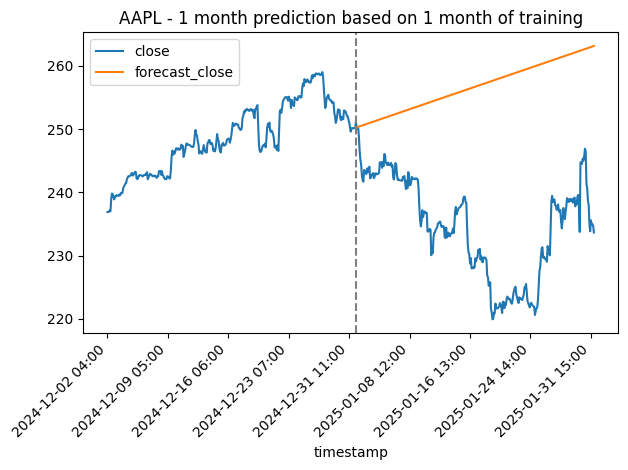

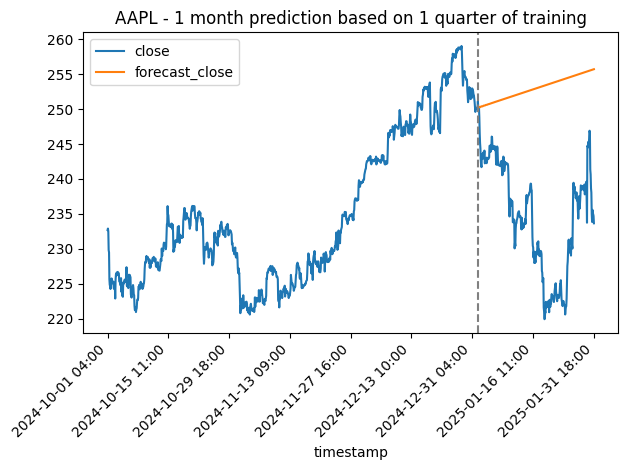

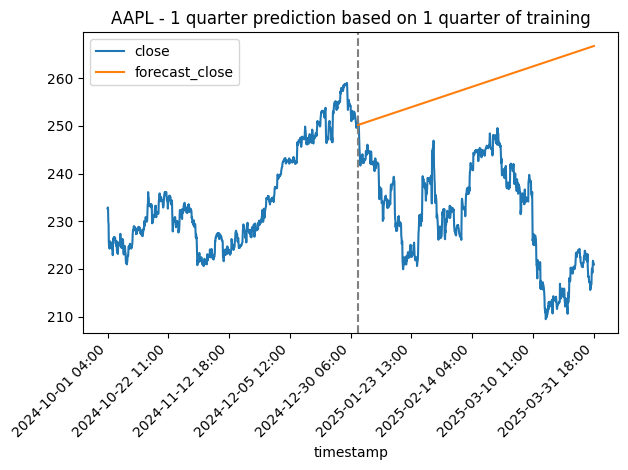

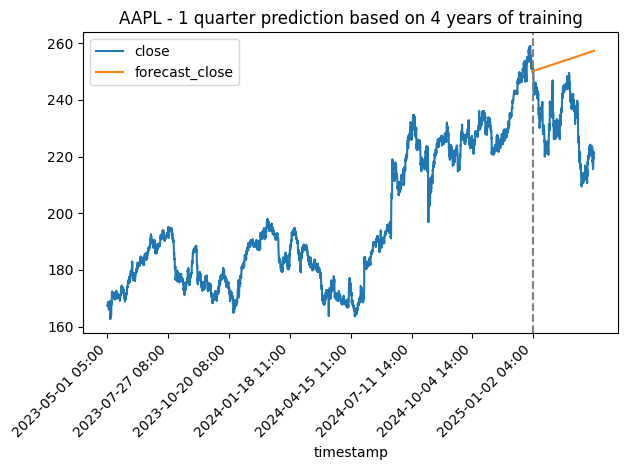

prediction     nrmse       mape        r2
0           1 day - 1 day  0.015892   1.366627 -0.438224
1          1 day - 1 week  0.024583   2.088612 -2.441633
2         1 day - 1 month  0.024384   2.067575 -2.386192
3       1 day - 1 quarter  0.023432   1.984373 -2.126728
4         1 week - 1 week  0.032853   3.134088 -2.397120
5        1 week - 1 month  0.051385   4.666875 -7.310322
6      1 week - 1 quarter  0.045217   4.110412 -5.435038
7       1 month - 1 month  0.103662   9.567293 -8.590974
8     1 month - 1 quarter  0.086578   7.954345 -5.690265
9   1 quarter - 1 quarter  0.130739  11.963286 -7.250442
10    1 quarter - 4 years  0.108832   9.886833 -4.717119

In [10]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])

aapl_day_day, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_day, aapl_test_day, 'close', "AAPL - 1 day prediction based on 1 day of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 day', nrmse, mape, r2]
aapl_day_week, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_week, aapl_test_day, 'close', "AAPL - 1 day prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 week', nrmse, mape, r2]
aapl_day_month, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_month, aapl_test_day, 'close', "AAPL - 1 day prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 month', nrmse, mape, r2]
aapl_day_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_quarter, aapl_test_day, 'close', "AAPL - 1 day prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 quarter', nrmse, mape, r2]

aapl_week_week, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_week, aapl_test_week, 'close', "AAPL - 1 week prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 week', nrmse, mape, r2]
aapl_week_month, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_month, aapl_test_week, 'close', "AAPL - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
aapl_week_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_quarter, aapl_test_week, 'close', "AAPL - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

aapl_month_month, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_month, aapl_test_month, 'close', "AAPL - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
aapl_month_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_quarter, aapl_test_month, 'close', "AAPL - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

aapl_quarter_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_quarter, aapl_test_quarter, 'close', "AAPL - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
aapl_quarter_full, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train, aapl_test_quarter, 'close', "AAPL - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2

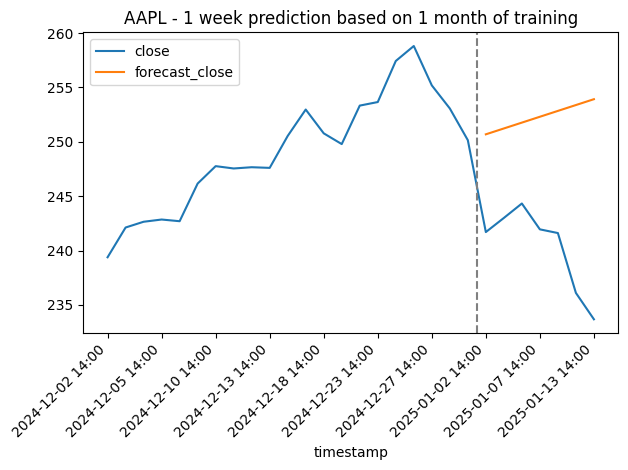

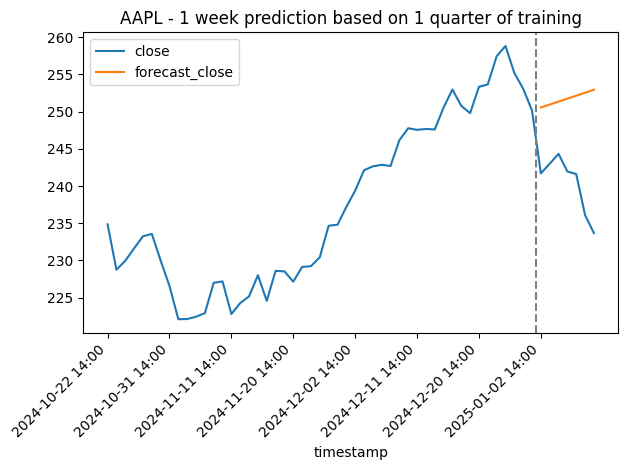

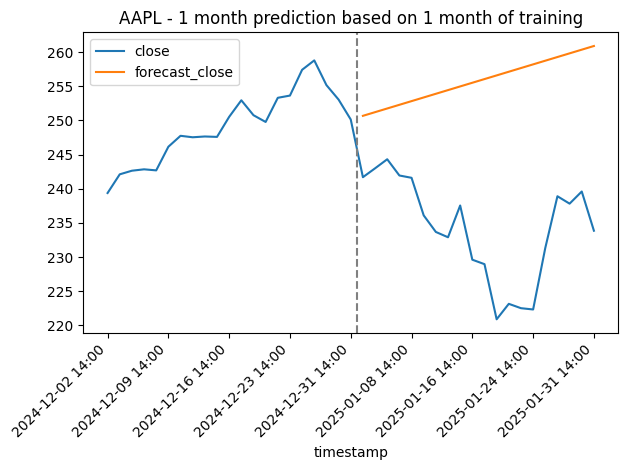

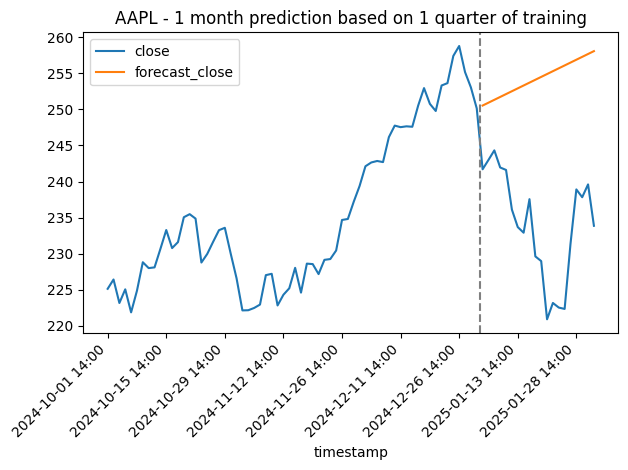

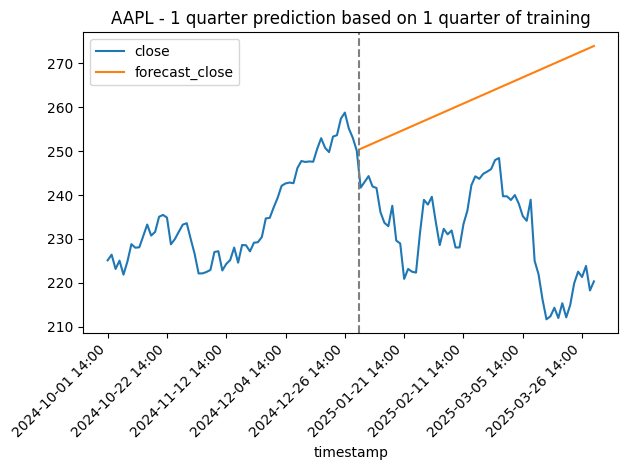

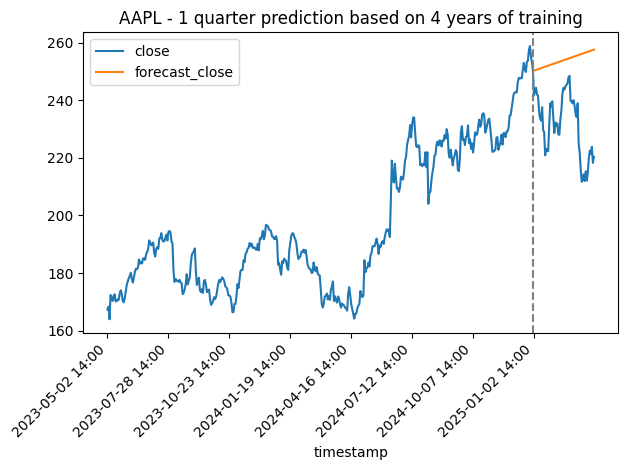

prediction     nrmse       mape         r2
0       1 week - 1 month  0.053224   5.008298 -11.542570
1     1 week - 1 quarter  0.050668   4.772132 -10.366568
2      1 month - 1 month  0.100632   9.403021  -9.407617
3    1 month - 1 quarter  0.093892   8.765062  -8.060178
4  1 quarter - 1 quarter  0.148851  13.676131  -9.774070
5    1 quarter - 4 years  0.109862  10.004431  -4.869015

In [11]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])

aapl_week_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_month_h, aapl_test_week_h, 'close', "AAPL - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
aapl_week_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_quarter_h, aapl_test_week_h, 'close', "AAPL - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

aapl_month_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_month_h, aapl_test_month_h, 'close', "AAPL - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
aapl_month_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_quarter_h, aapl_test_month_h, 'close', "AAPL - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

aapl_quarter_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_quarter_h, aapl_test_quarter_h, 'close', "AAPL - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
aapl_quarter_full_h, nrmse, mape, r2 = get_model_and_plot_forecast(aapl_train_h, aapl_test_quarter_h, 'close', "AAPL - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2

# BTC

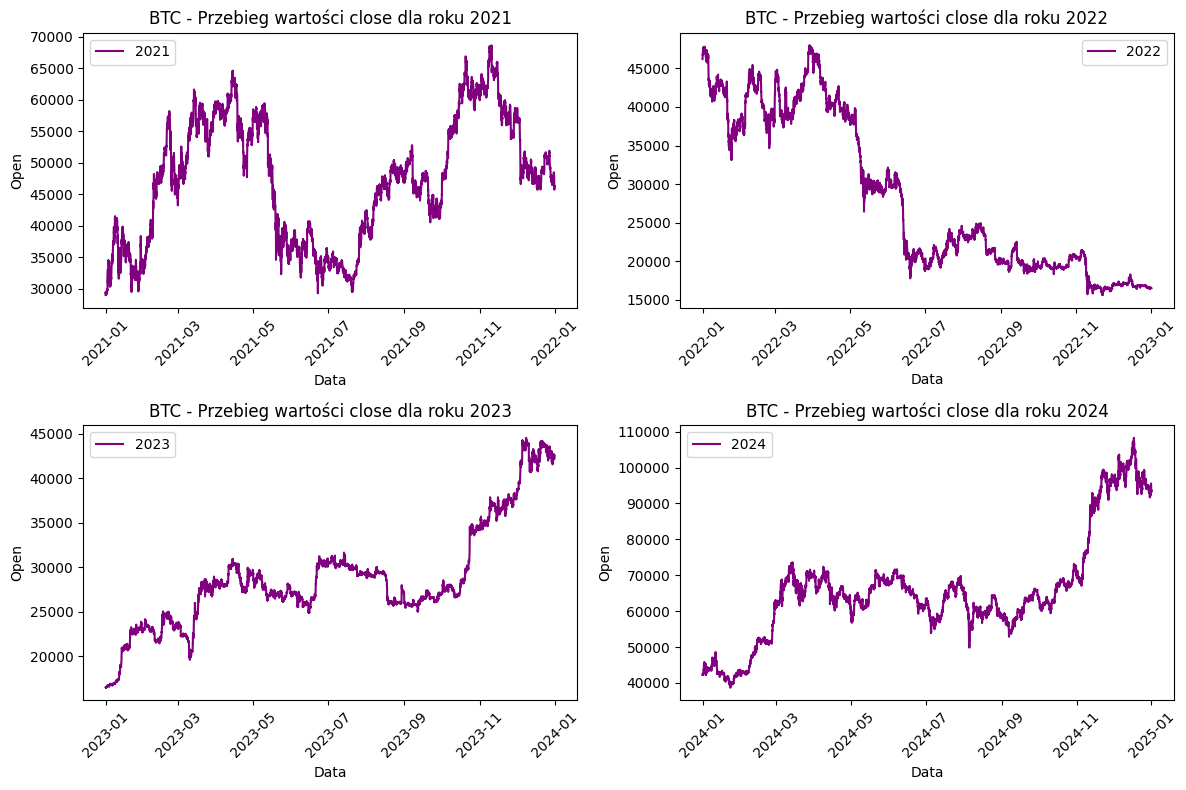

In [12]:
plot_stock_data(BTC, 'BTC', 'close', 'purple')

In [13]:
btc_data, btc_train, btc_test = get_data(BTC)
btc_train_day, btc_test_day = extract_period(btc_train, btc_test, 'day')
btc_train_week, btc_test_week = extract_period(btc_train, btc_test, 'week')
btc_train_month, btc_test_month = extract_period(btc_train, btc_test, 'month')
btc_train_quarter, btc_test_quarter = extract_period(btc_train, btc_test, 'quarter')

btc_train_h, btc_test_h = filter_by_hour(btc_train, btc_test, 14)
btc_train_day_h, btc_test_day_h = filter_by_hour(btc_train_day, btc_test_day, 14)
btc_train_week_h, btc_test_week_h = filter_by_hour(btc_train_week, btc_test_week, 14)
btc_train_month_h, btc_test_month_h = filter_by_hour(btc_train_month, btc_test_month, 14)
btc_train_quarter_h, btc_test_quarter_h = filter_by_hour(btc_train_quarter, btc_test_quarter, 14)

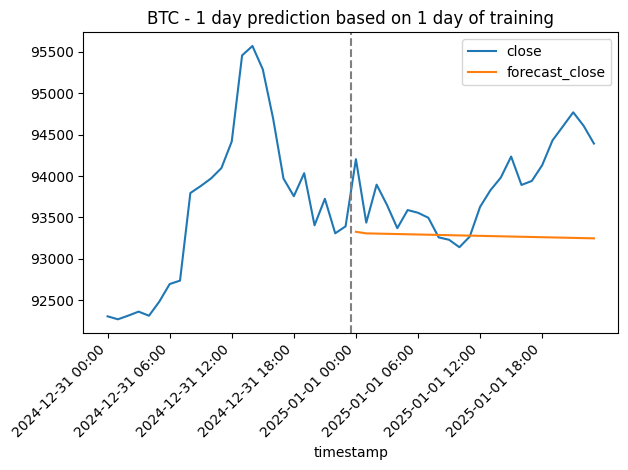

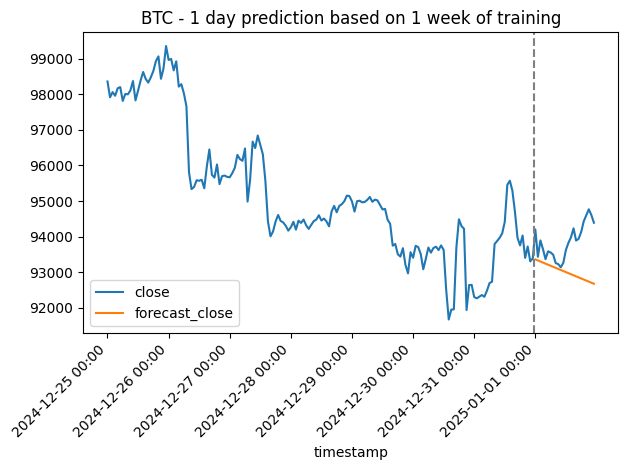

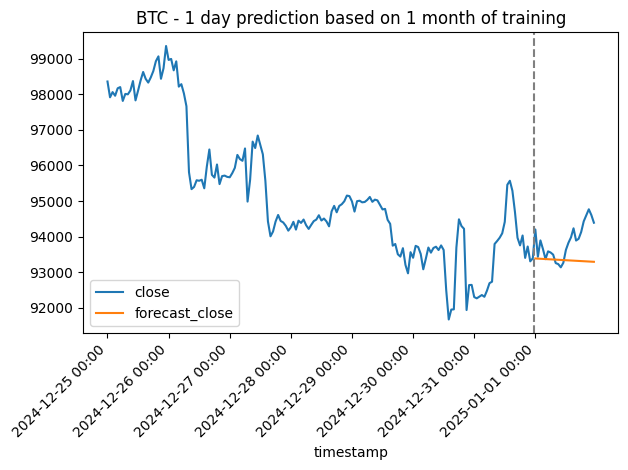

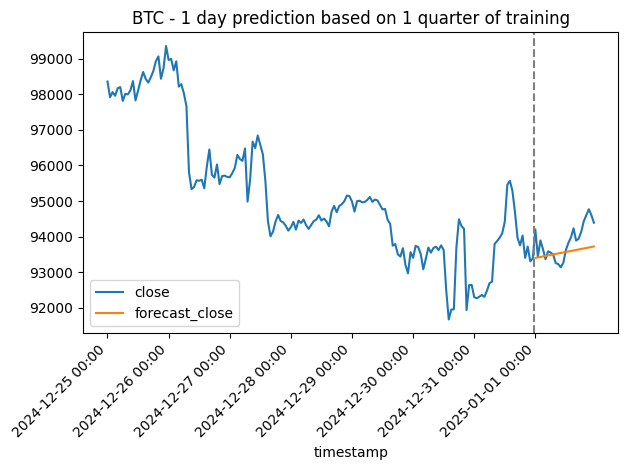

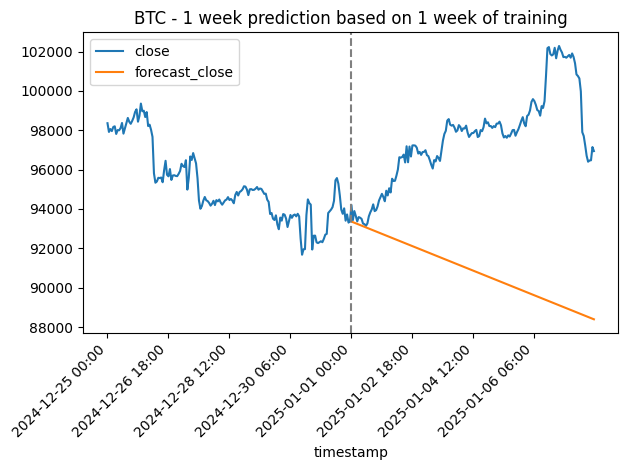

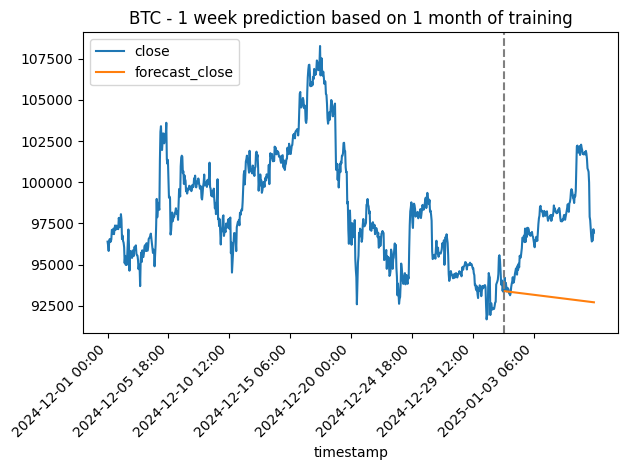

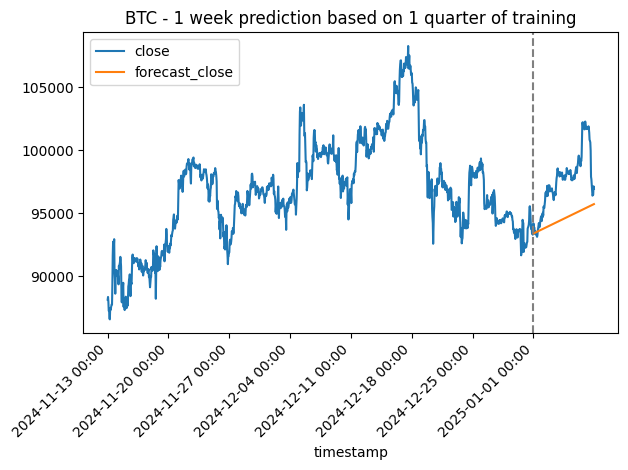

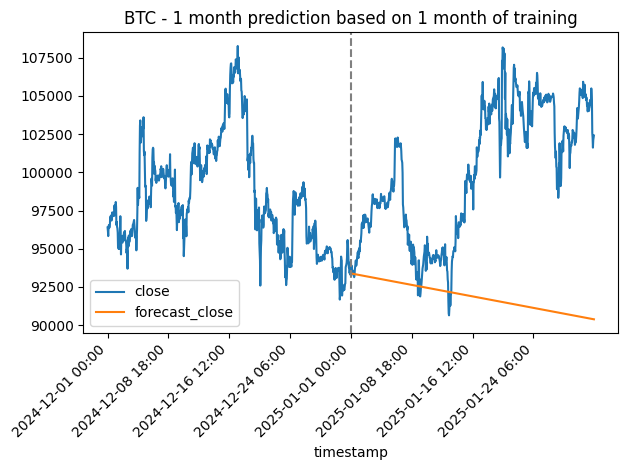

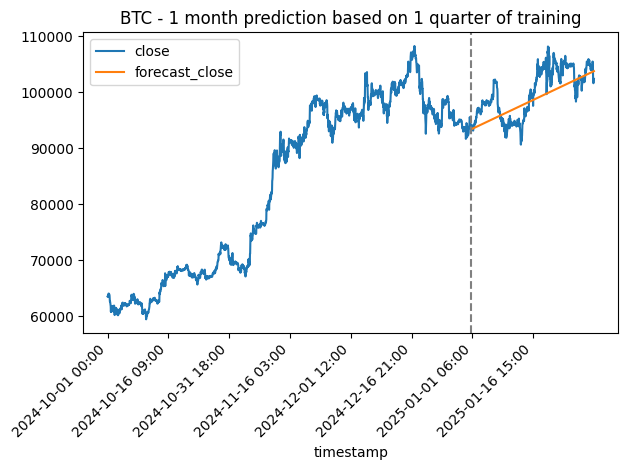

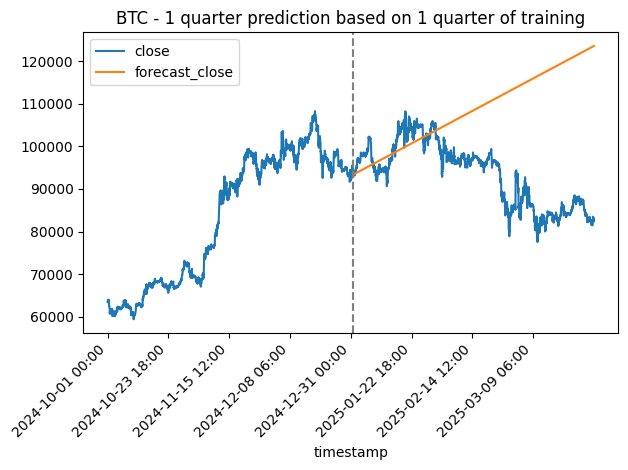

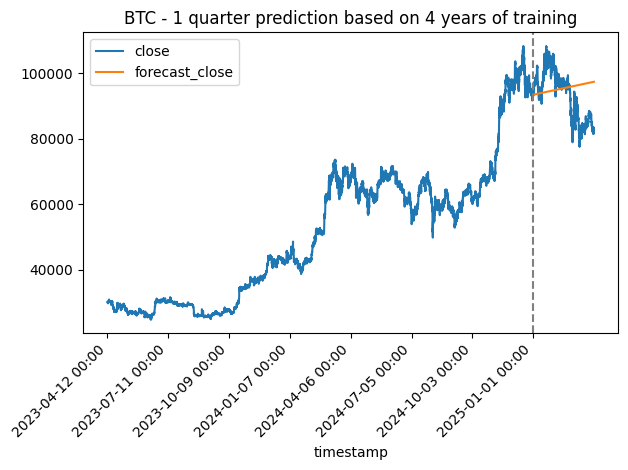

prediction     nrmse       mape         r2
0           1 day - 1 day  0.008021   0.632898  -1.545677
1          1 day - 1 week  0.011142   0.886793  -3.911408
2         1 day - 1 month  0.007575   0.590138  -1.270367
3       1 day - 1 quarter  0.005382   0.428030  -0.146121
4         1 week - 1 week  0.078317   6.839754 -10.117434
5        1 week - 1 month  0.053281   4.645660  -4.145591
6      1 week - 1 quarter  0.036270   3.116778  -1.384386
7       1 month - 1 month  0.094709   7.897730  -3.868908
8     1 month - 1 quarter  0.032528   2.755547   0.425675
9   1 quarter - 1 quarter  0.229354  18.836519  -7.274924
10    1 quarter - 4 years  0.092053   7.845616  -0.332994

In [14]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])

btc_day_day, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_day, btc_test_day, 'close', "BTC - 1 day prediction based on 1 day of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 day', nrmse, mape, r2]
btc_day_week, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_week, btc_test_day, 'close', "BTC - 1 day prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 week', nrmse, mape, r2]
btc_day_month, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_month, btc_test_day, 'close', "BTC - 1 day prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 month', nrmse, mape, r2]
btc_day_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_quarter, btc_test_day, 'close', "BTC - 1 day prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 quarter', nrmse, mape, r2]

btc_week_week, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_week, btc_test_week, 'close', "BTC - 1 week prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 week', nrmse, mape, r2]
btc_week_month, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_month, btc_test_week, 'close', "BTC - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
btc_week_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_quarter, btc_test_week, 'close', "BTC - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

btc_month_month, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_month, btc_test_month, 'close', "BTC - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
btc_month_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_quarter, btc_test_month, 'close', "BTC - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

btc_quarter_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_quarter, btc_test_quarter, 'close', "BTC - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
btc_quarter_full, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train, btc_test_quarter, 'close', "BTC - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2

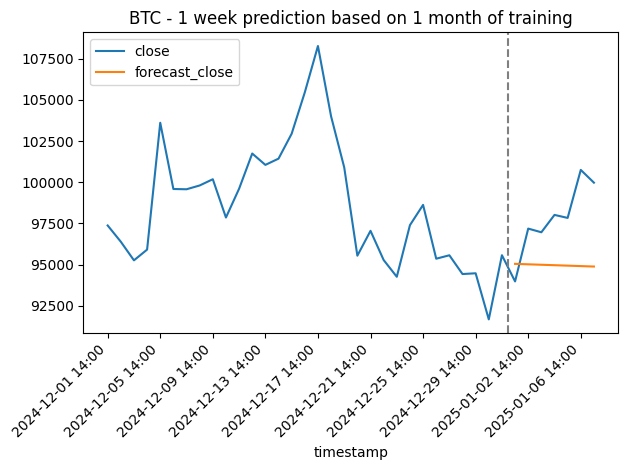

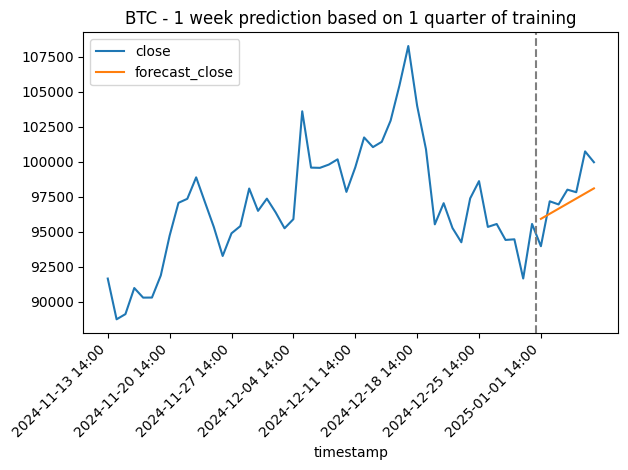

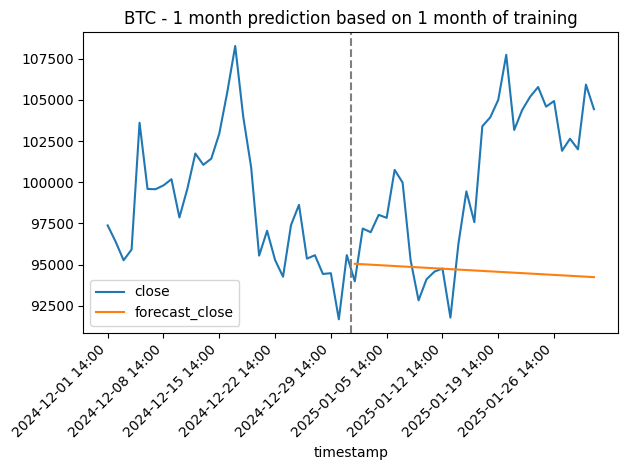

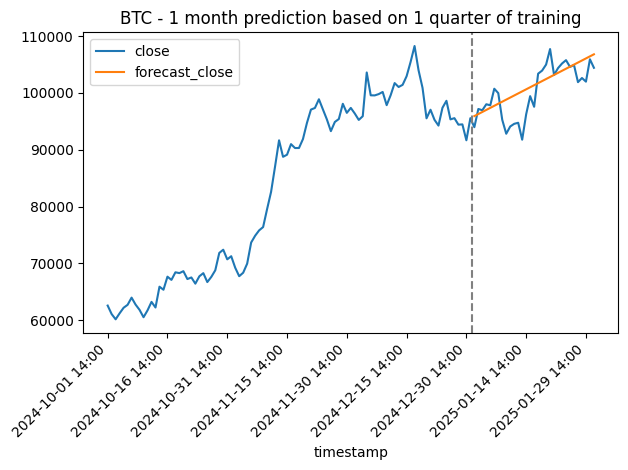

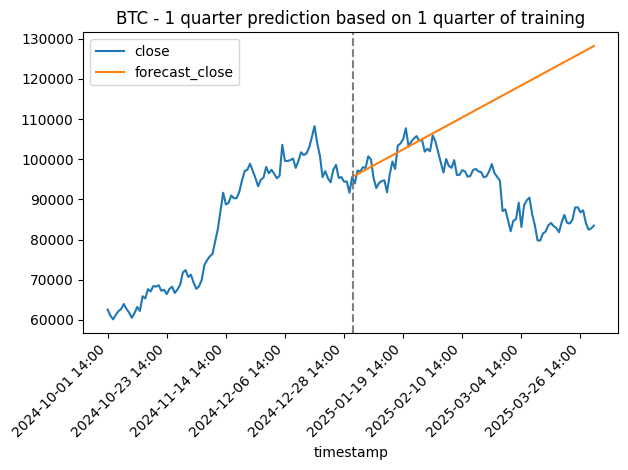

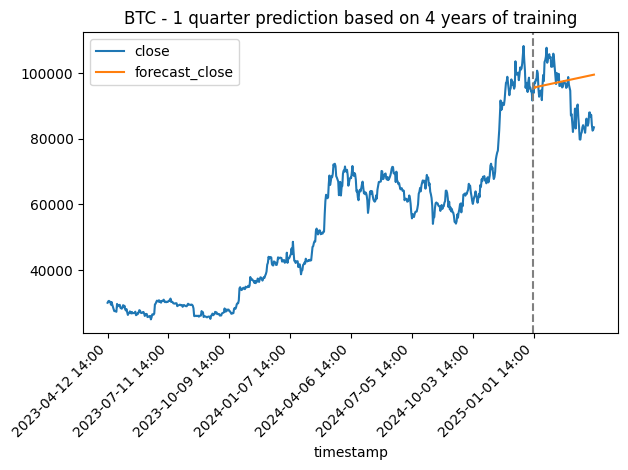

prediction     nrmse       mape        r2
0       1 week - 1 month  0.036140   3.194969 -2.001484
1     1 week - 1 quarter  0.016576   1.376443  0.368574
2      1 month - 1 month  0.072629   5.831602 -1.601738
3    1 month - 1 quarter  0.032866   2.645106  0.467235
4  1 quarter - 1 quarter  0.264108  21.927544 -9.283913
5    1 quarter - 4 years  0.102404   8.502927 -0.546062

In [15]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])


btc_week_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_month_h, btc_test_week_h, 'close', "BTC - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
btc_week_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_quarter_h, btc_test_week_h, 'close', "BTC - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

btc_month_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_month_h, btc_test_month_h, 'close', "BTC - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
btc_month_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_quarter_h, btc_test_month_h, 'close', "BTC - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

btc_quarter_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_quarter_h, btc_test_quarter_h, 'close', "BTC - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
btc_quarter_full_h, nrmse, mape, r2 = get_model_and_plot_forecast(btc_train_h, btc_test_quarter_h, 'close', "BTC - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2

# ETH

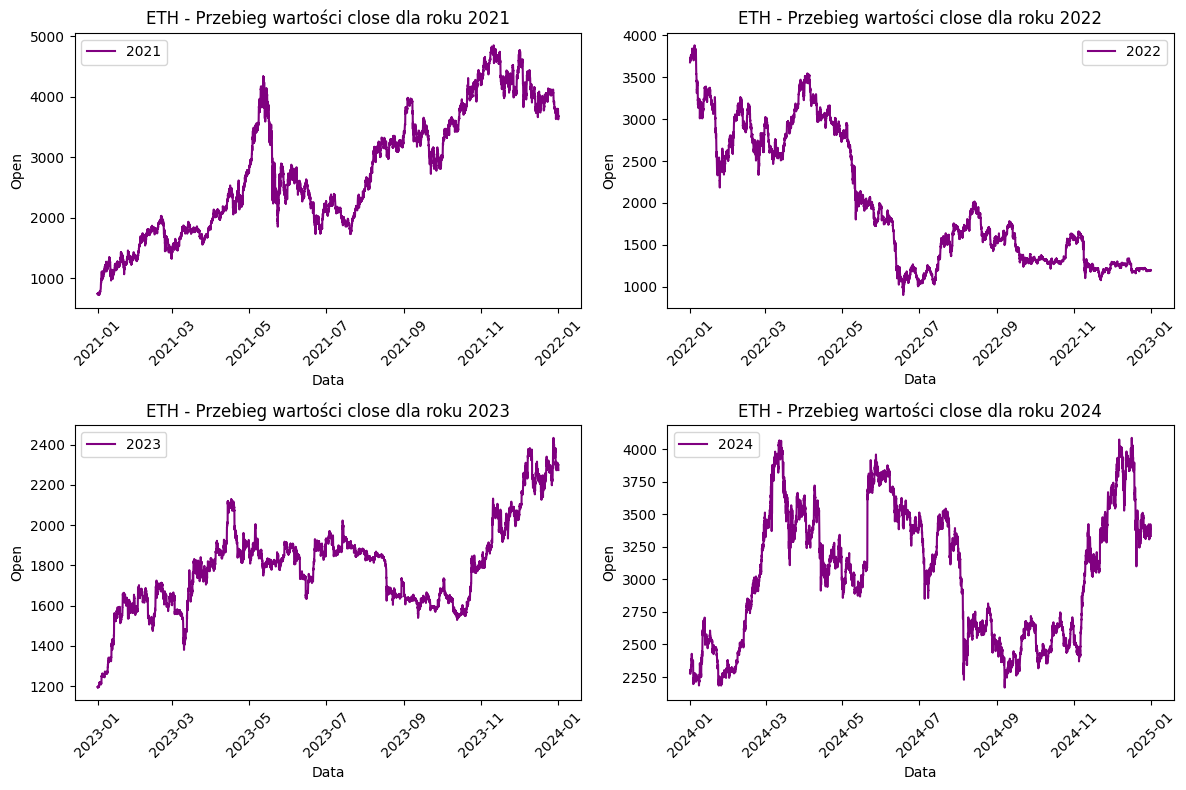

In [16]:
plot_stock_data(ETH, 'ETH', 'close', 'purple')

In [17]:
eth_data, eth_train, eth_test = get_data(ETH)
eth_train_day, eth_test_day = extract_period(eth_train, eth_test, 'day')
eth_train_week, eth_test_week = extract_period(eth_train, eth_test, 'week')
eth_train_month, eth_test_month = extract_period(eth_train, eth_test, 'month')
eth_train_quarter, eth_test_quarter = extract_period(eth_train, eth_test, 'quarter')

eth_train_h, eth_test_h = filter_by_hour(eth_train, eth_test, 14)
eth_train_day_h, eth_test_day_h = filter_by_hour(eth_train_day, eth_test_day, 14)
eth_train_week_h, eth_test_week_h = filter_by_hour(eth_train_week, eth_test_week, 14)
eth_train_month_h, eth_test_month_h = filter_by_hour(eth_train_month, eth_test_month, 14)
eth_train_quarter_h, eth_test_quarter_h = filter_by_hour(eth_train_quarter, eth_test_quarter, 14)

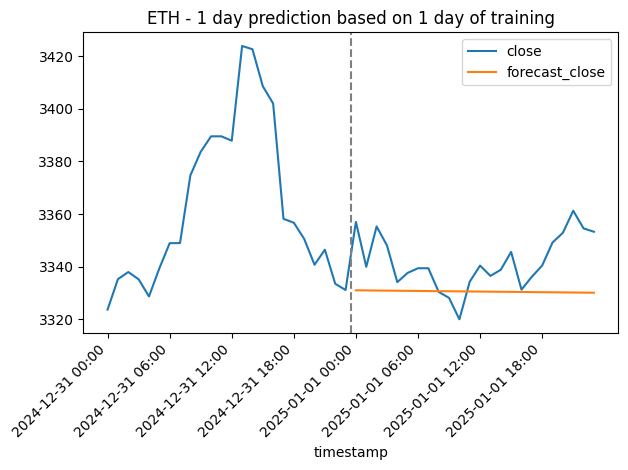

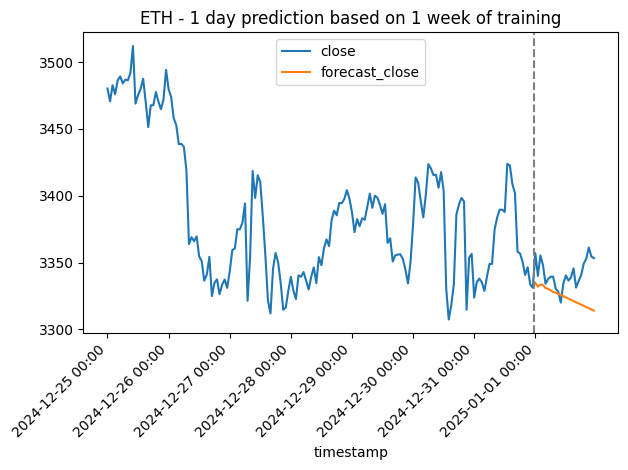

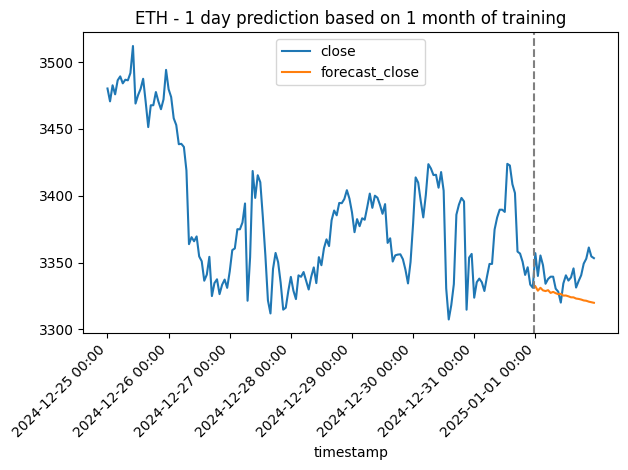

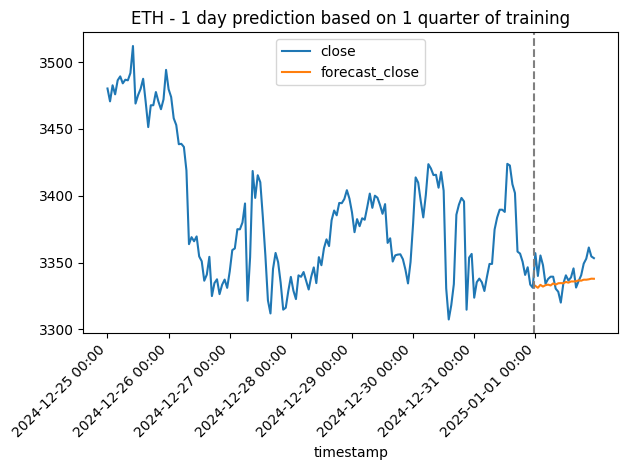

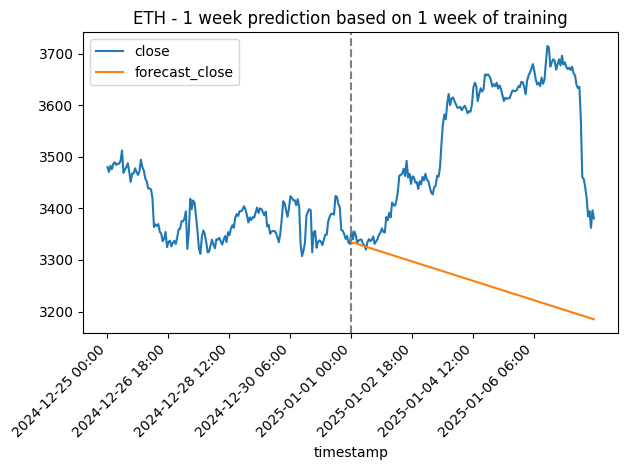

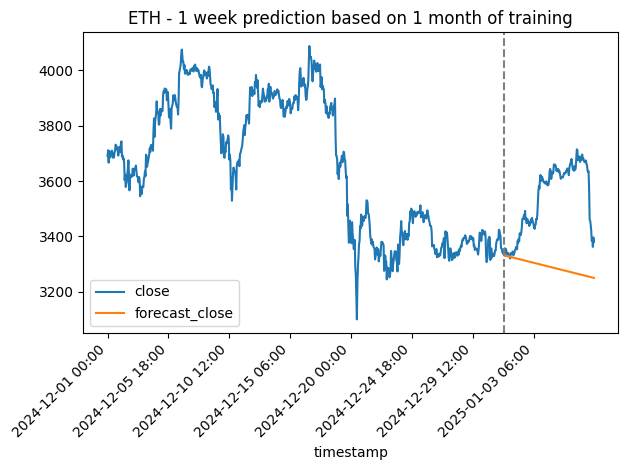

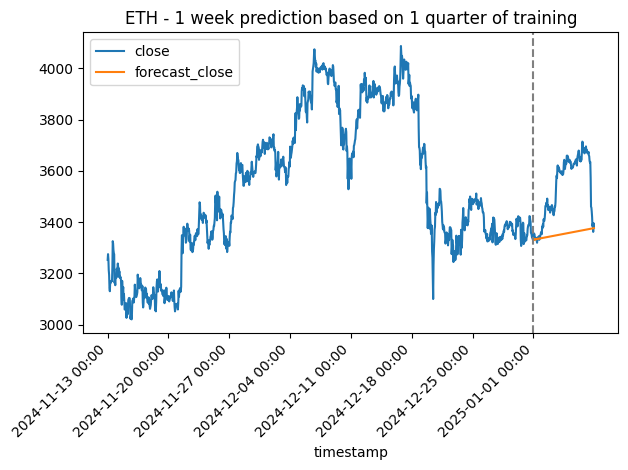

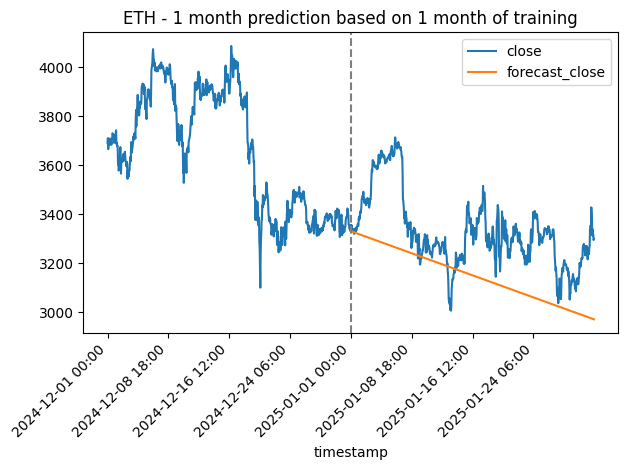

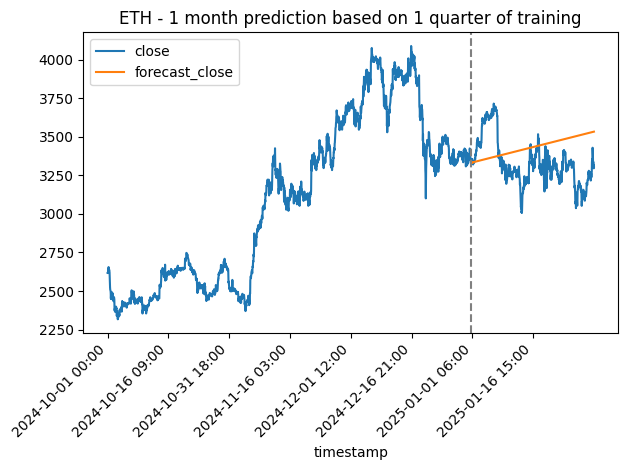

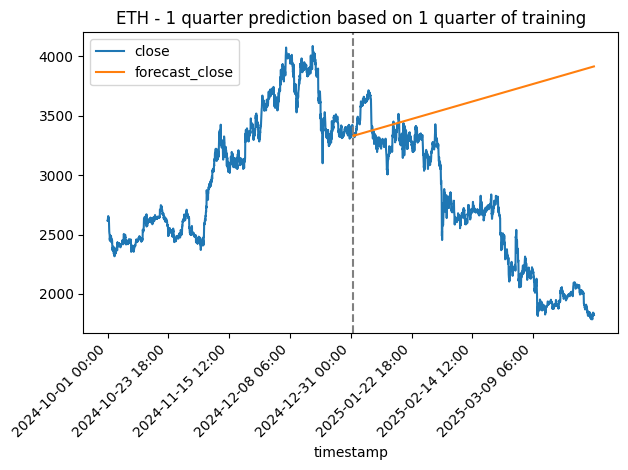

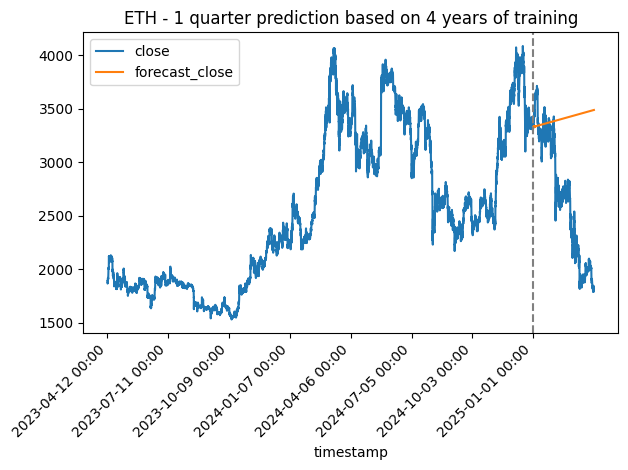

prediction     nrmse       mape        r2
0           1 day - 1 day  0.004539   0.370204 -1.265414
1          1 day - 1 week  0.006527   0.538270 -3.683082
2         1 day - 1 month  0.005957   0.507266 -2.901584
3       1 day - 1 quarter  0.003570   0.279548 -0.400952
4         1 week - 1 week  0.090312   7.734115 -5.855334
5        1 week - 1 month  0.080469   6.879517 -4.442512
6      1 week - 1 quarter  0.061019   5.111687 -2.129480
7       1 month - 1 month  0.065066   5.457282 -1.117884
8     1 month - 1 quarter  0.064457   5.636348 -1.078451
9   1 quarter - 1 quarter  0.446572  44.073802 -3.436986
10    1 quarter - 4 years  0.356303  34.839988 -1.824520

In [18]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])

eth_day_day, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_day, eth_test_day, 'close', "ETH - 1 day prediction based on 1 day of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 day', nrmse, mape, r2]
eth_day_week, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_week, eth_test_day, 'close', "ETH - 1 day prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 week', nrmse, mape, r2]
eth_day_month, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_month, eth_test_day, 'close', "ETH - 1 day prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 month', nrmse, mape, r2]
eth_day_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_quarter, eth_test_day, 'close', "ETH - 1 day prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 quarter', nrmse, mape, r2]

eth_week_week, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_week, eth_test_week, 'close', "ETH - 1 week prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 week', nrmse, mape, r2]
eth_week_month, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_month, eth_test_week, 'close', "ETH - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
eth_week_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_quarter, eth_test_week, 'close', "ETH - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

eth_month_month, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_month, eth_test_month, 'close', "ETH - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
eth_month_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_quarter, eth_test_month, 'close', "ETH - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

eth_quarter_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_quarter, eth_test_quarter, 'close', "ETH - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
eth_quarter_full, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train, eth_test_quarter, 'close', "ETH - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2

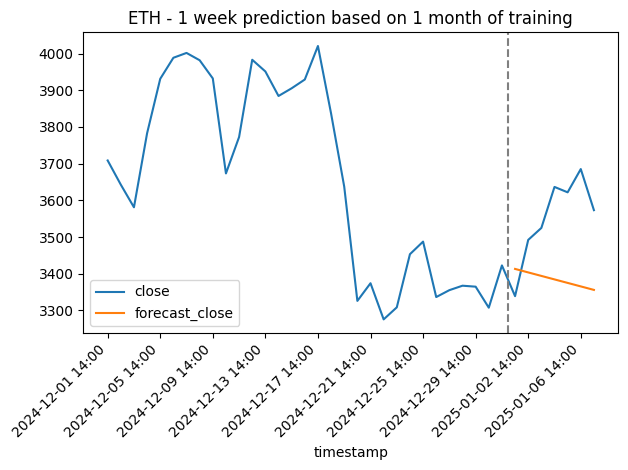

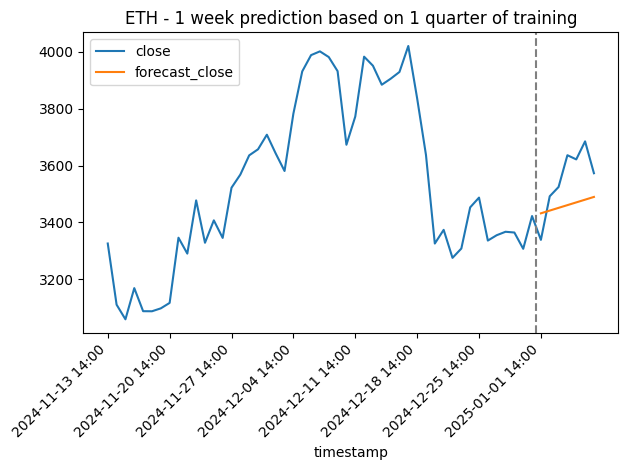

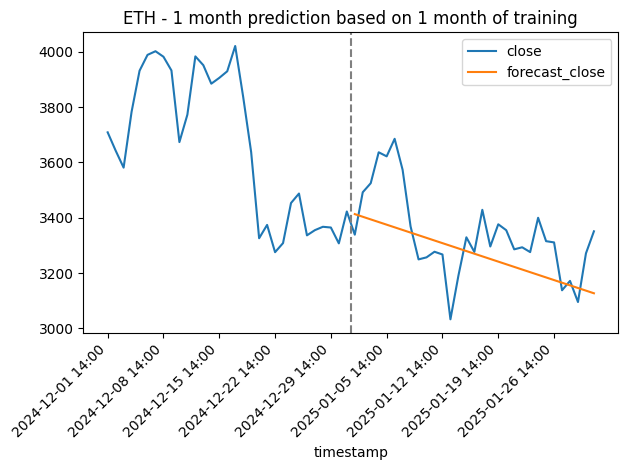

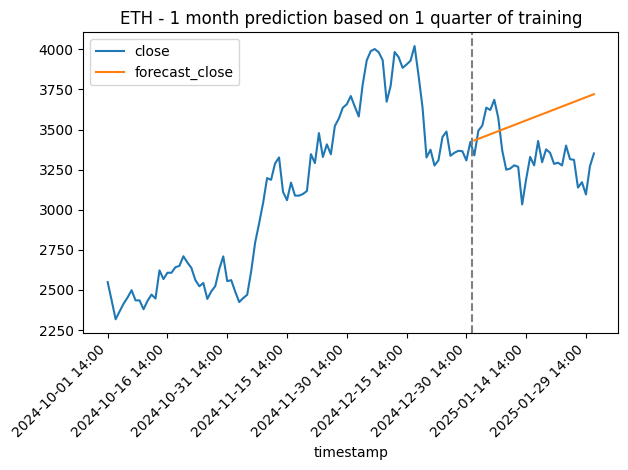

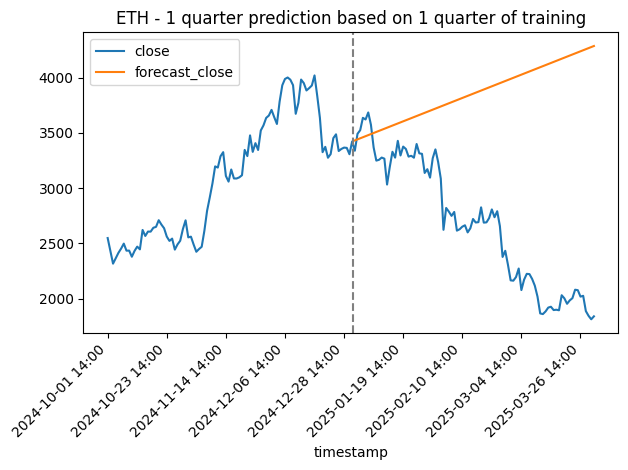

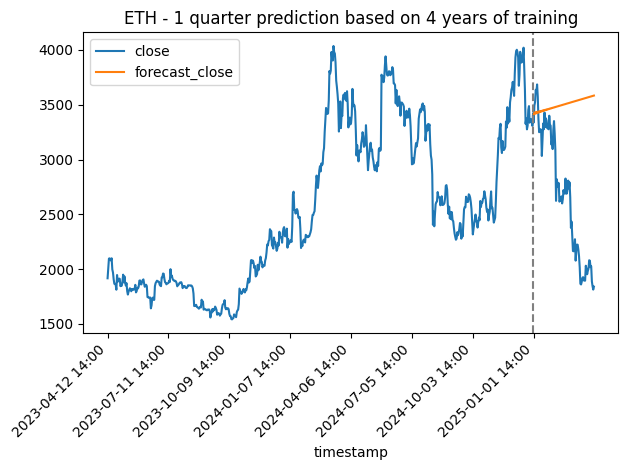

prediction     nrmse       mape        r2
0       1 week - 1 month  0.058706   5.283698 -2.806807
1     1 week - 1 quarter  0.036746   3.317217 -0.491421
2      1 month - 1 month  0.042817   3.451639  0.100012
3    1 month - 1 quarter  0.095223   8.725141 -3.451239
4  1 quarter - 1 quarter  0.536320  53.771449 -5.255776
5    1 quarter - 4 years  0.385066  38.230319 -2.224807

In [19]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])

eth_week_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_month_h, eth_test_week_h, 'close', "ETH - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
eth_week_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_quarter_h, eth_test_week_h, 'close', "ETH - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

eth_month_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_month_h, eth_test_month_h, 'close', "ETH - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
eth_month_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_quarter_h, eth_test_month_h, 'close', "ETH - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

eth_quarter_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_quarter_h, eth_test_quarter_h, 'close', "ETH - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
eth_quarter_full_h, nrmse, mape, r2 = get_model_and_plot_forecast(eth_train_h, eth_test_quarter_h, 'close', "ETH - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2

# SPY

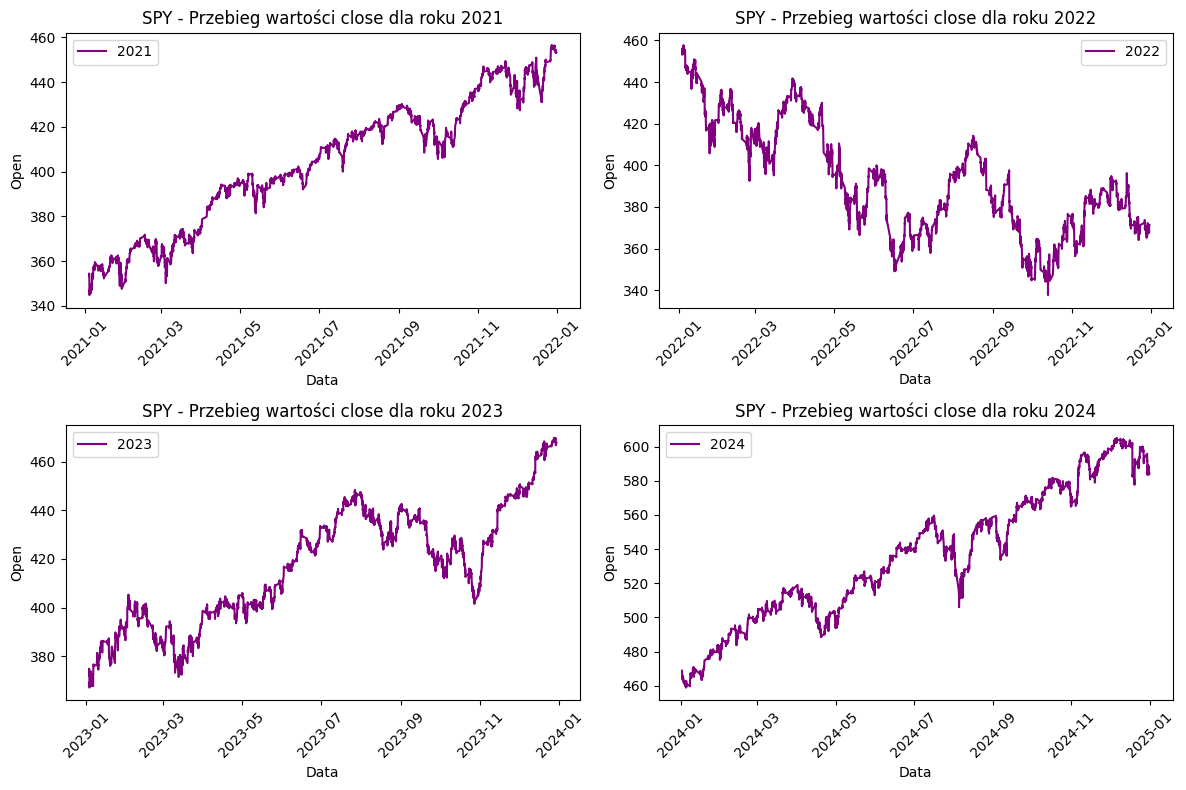

In [20]:
plot_stock_data(SPY, 'SPY', 'close', 'purple')

In [21]:
spy_data, spy_train, spy_test = get_data(SPY)
spy_train_day, spy_test_day = extract_period(spy_train, spy_test, 'day')
spy_train_week, spy_test_week = extract_period(spy_train, spy_test, 'week')
spy_train_month, spy_test_month = extract_period(spy_train, spy_test, 'month')
spy_train_quarter, spy_test_quarter = extract_period(spy_train, spy_test, 'quarter')

spy_train_h, spy_test_h = filter_by_hour(spy_train, spy_test, 14)
spy_train_day_h, spy_test_day_h = filter_by_hour(spy_train_day, spy_test_day, 14)
spy_train_week_h, spy_test_week_h = filter_by_hour(spy_train_week, spy_test_week, 14)
spy_train_month_h, spy_test_month_h = filter_by_hour(spy_train_month, spy_test_month, 14)
spy_train_quarter_h, spy_test_quarter_h = filter_by_hour(spy_train_quarter, spy_test_quarter, 14)

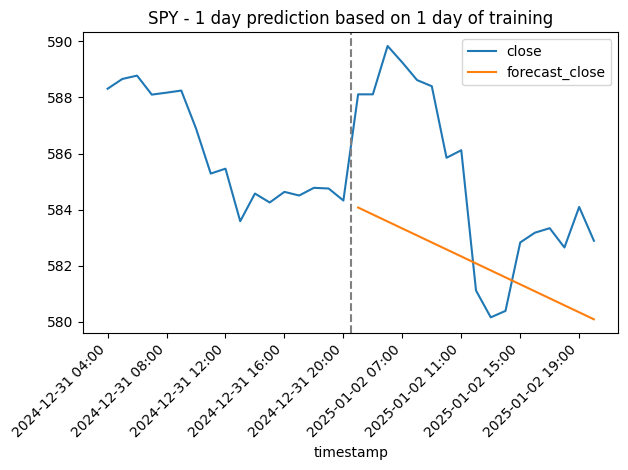

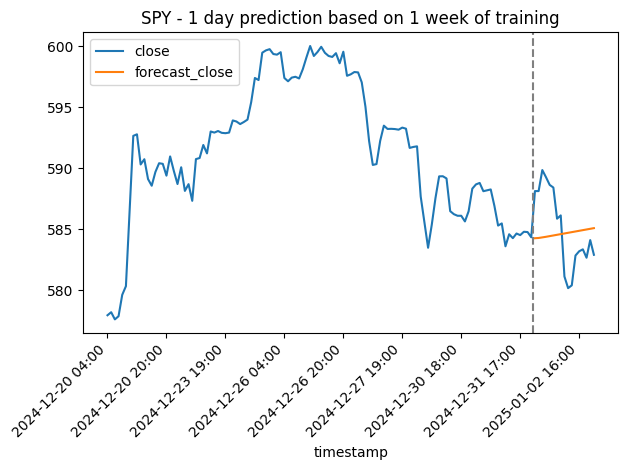

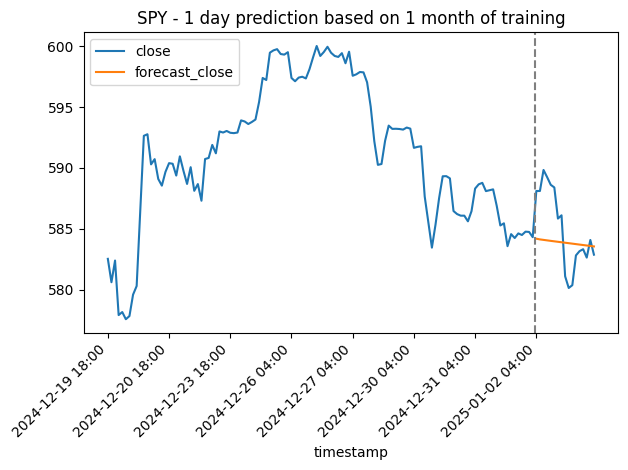

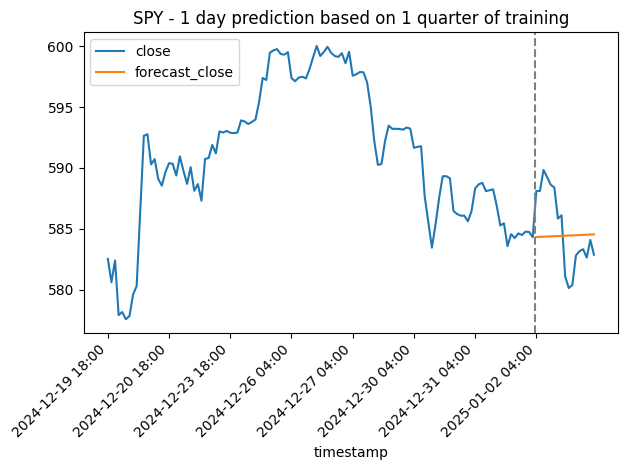

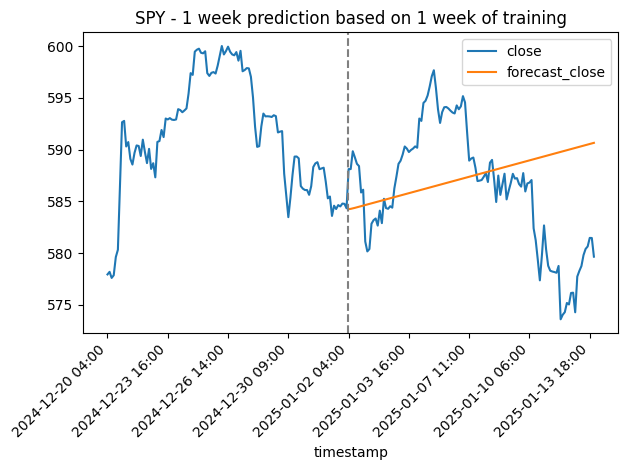

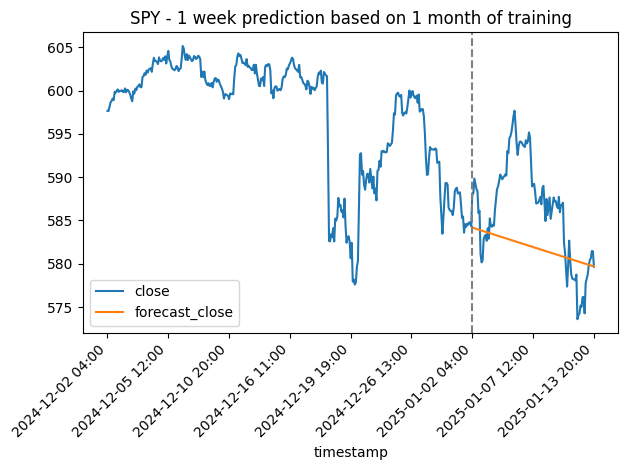

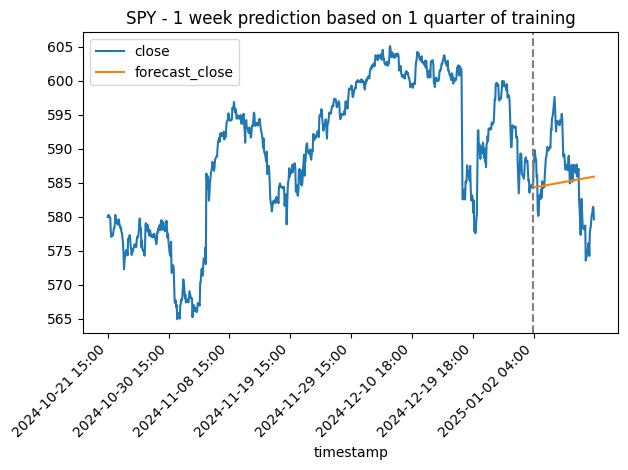

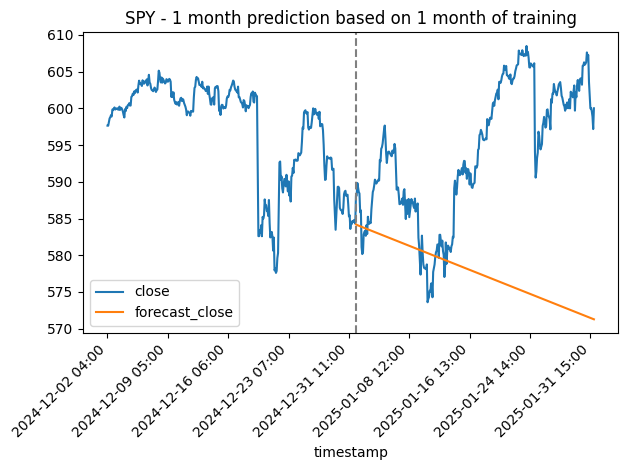

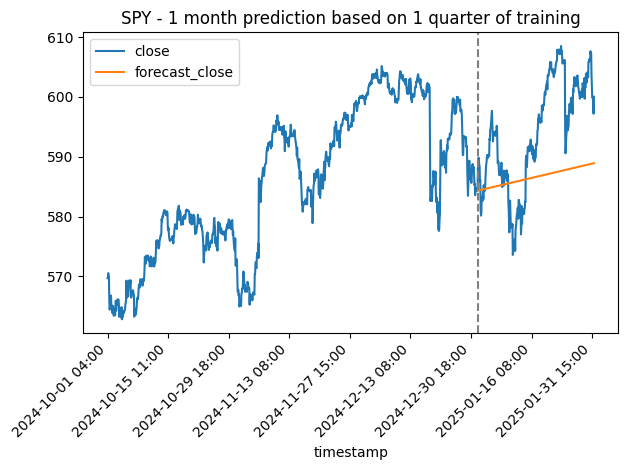

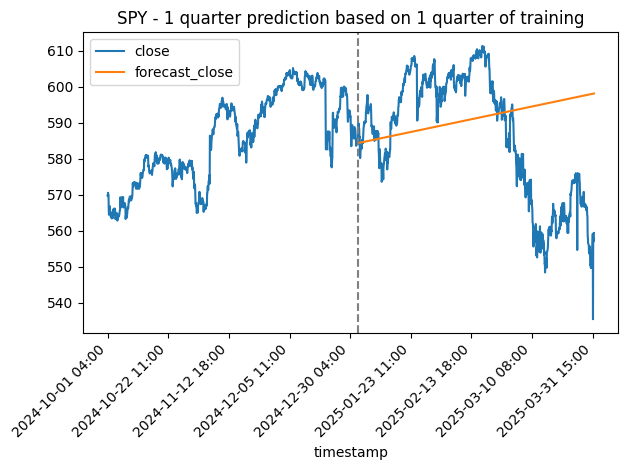

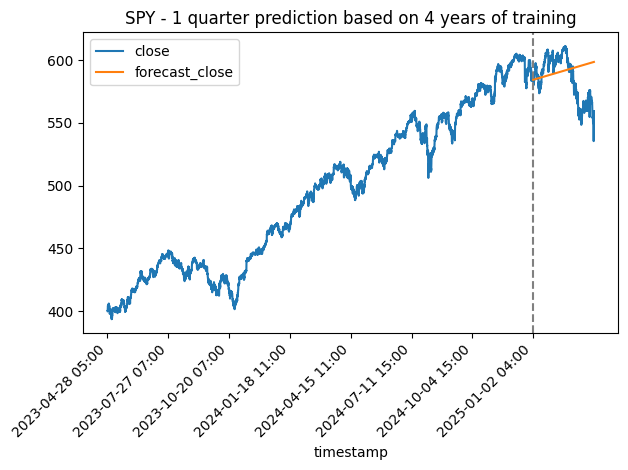

prediction     nrmse      mape        r2
0           1 day - 1 day  0.006424  0.574103 -0.421071
1          1 day - 1 week  0.005767  0.524222 -0.145114
2         1 day - 1 month  0.005497  0.459068 -0.040546
3       1 day - 1 quarter  0.005555  0.493043 -0.062595
4         1 week - 1 week  0.012200  0.968479 -0.493355
5        1 week - 1 month  0.011549  0.948045 -0.338406
6      1 week - 1 quarter  0.010584  0.876049 -0.124124
7       1 month - 1 month  0.034041  2.786862 -3.967441
8     1 month - 1 quarter  0.018464  1.569123 -0.461382
9   1 quarter - 1 quarter  0.035210  2.913635 -0.424762
10    1 quarter - 4 years  0.035476  2.925052 -0.446398

In [22]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])

spy_day_day, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_day, spy_test_day, 'close', "SPY - 1 day prediction based on 1 day of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 day', nrmse, mape, r2]
spy_day_week, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_week, spy_test_day, 'close', "SPY - 1 day prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 week', nrmse, mape, r2]
spy_day_month, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_month, spy_test_day, 'close', "SPY - 1 day prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 month', nrmse, mape, r2]
spy_day_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_quarter, spy_test_day, 'close', "SPY - 1 day prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 day - 1 quarter', nrmse, mape, r2]

spy_week_week, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_week, spy_test_week, 'close', "SPY - 1 week prediction based on 1 week of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 week', nrmse, mape, r2]
spy_week_month, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_month, spy_test_week, 'close', "SPY - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
spy_week_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_quarter, spy_test_week, 'close', "SPY - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

spy_month_month, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_month, spy_test_month, 'close', "SPY - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
spy_month_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_quarter, spy_test_month, 'close', "SPY - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

spy_quarter_quarter, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_quarter, spy_test_quarter, 'close', "SPY - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
spy_quarter_full, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train, spy_test_quarter, 'close', "SPY - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2

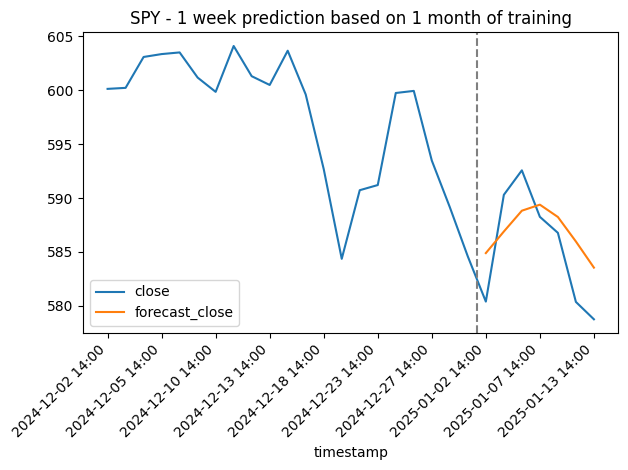

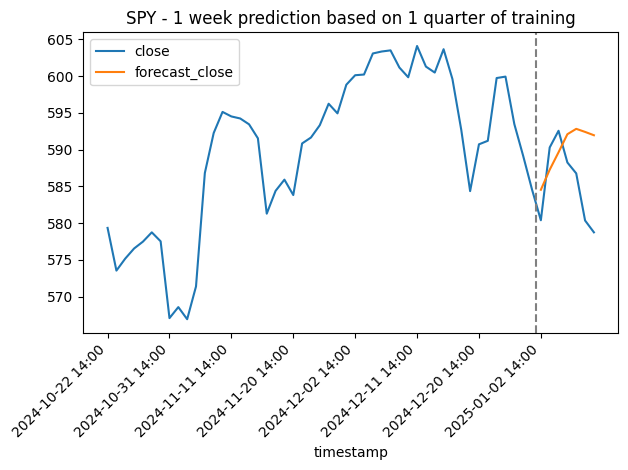

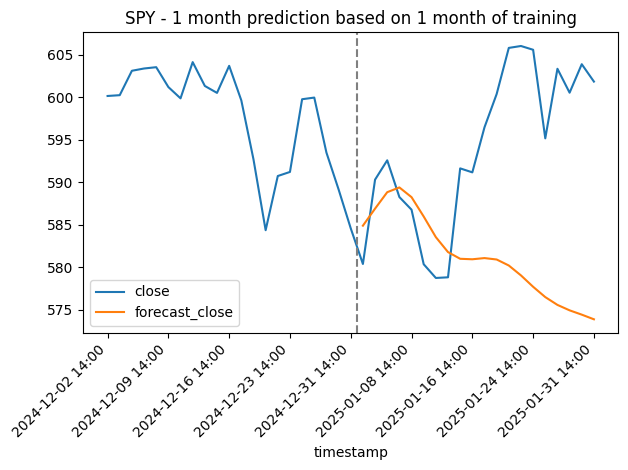

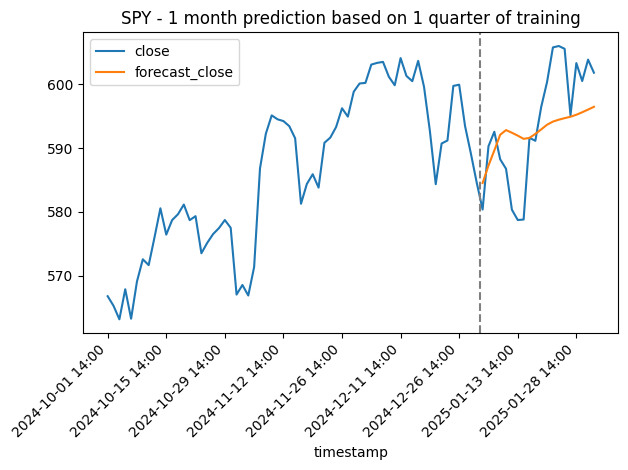

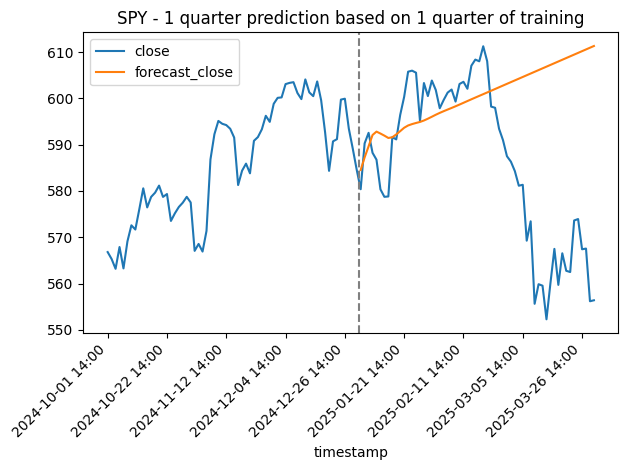

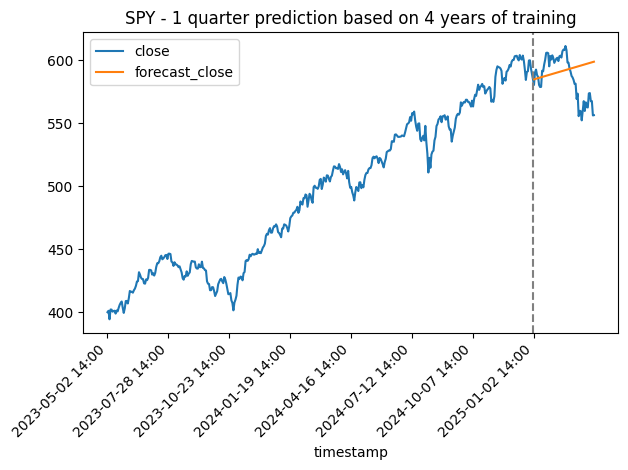

prediction     nrmse      mape        r2
0       1 week - 1 month  0.006579  0.603287  0.424091
1     1 week - 1 quarter  0.013022  1.110173 -1.256142
2      1 month - 1 month  0.030401  2.442655 -2.831768
3    1 month - 1 quarter  0.012989  1.091895  0.300505
4  1 quarter - 1 quarter  0.044295  3.279177 -1.301248
5    1 quarter - 4 years  0.035401  2.938482 -0.469941

In [23]:
nrmse_mape_r2=pd.DataFrame(columns=['prediction', 'nrmse', 'mape', 'r2'])


spy_week_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_month_h, spy_test_week_h, 'close', "SPY - 1 week prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 month', nrmse, mape, r2]
spy_week_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_quarter_h, spy_test_week_h, 'close', "SPY - 1 week prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 week - 1 quarter', nrmse, mape, r2]

spy_month_month_h, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_month_h, spy_test_month_h, 'close', "SPY - 1 month prediction based on 1 month of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 month', nrmse, mape, r2]
spy_month_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_quarter_h, spy_test_month_h, 'close', "SPY - 1 month prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 month - 1 quarter', nrmse, mape, r2]

spy_quarter_quarter_h, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_quarter_h, spy_test_quarter_h, 'close', "SPY - 1 quarter prediction based on 1 quarter of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 1 quarter', nrmse, mape, r2]
spy_quarter_full_h, nrmse, mape, r2 = get_model_and_plot_forecast(spy_train_h, spy_test_quarter_h, 'close', "SPY - 1 quarter prediction based on 4 years of training")
nrmse_mape_r2.loc[len(nrmse_mape_r2)] = ['1 quarter - 4 years', nrmse, mape, r2]

nrmse_mape_r2